In [1]:
%matplotlib inline
from IPython.display import clear_output
import os
from copy import deepcopy

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models import ConvNet
from helper import ExperimentLogger, display_train_stats
from fl_devices import Server, Client
from data_utils import split_noniid, CustomSubset


torch.manual_seed(42)
np.random.seed(42)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


We will run experiments with the EMNIST data set of handwritten characters. We simulate a scenario with 10 clients and distribute the data among the clients in a non-iid way accoding to a dirichlet distribution parametrized with alpha=1.0 . The distribution of data is shown below.

In [2]:
N_CLIENTS = 10
DIRICHLET_ALPHA = 1.0


# data = datasets.EMNIST(root=".", split="byclass", download=True)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_data = datasets.CIFAR100(root='./cifar100', train=True, download=True, transform=transform)
test_data = datasets.CIFAR100(root='./cifar100', train=False, download=True, transform=transform)

# mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
#        'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
#        'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
#        'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
#        'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1')
mapp = np.array([
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd',
    'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
    'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
    'y', 'z', '!', '@', '#', '$', '%', '^', '&', '*',
    '(', ')', '-', '_', '=', '+', '[', ']', '{', '}',
    '|', ';', ':', "'", '"', ',', '.', '<', '>', '?',
    '/', '~', '`', '\\', ' ', '€', '£', '¥', '¢', '§', 
], dtype='<U1')


train_idcs = np.random.permutation(len(train_data))
test_idcs = np.random.permutation(len(test_data))
train_idcs, test_idcs = train_idcs[:10000], test_idcs[:10000]
train_labels = np.array(train_data.targets)

client_idcs = split_noniid(train_idcs, train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)

client_data = [CustomSubset(train_data, idcs) for idcs in client_idcs]
test_data = CustomSubset(test_data, test_idcs, transform)

Files already downloaded and verified
Files already downloaded and verified


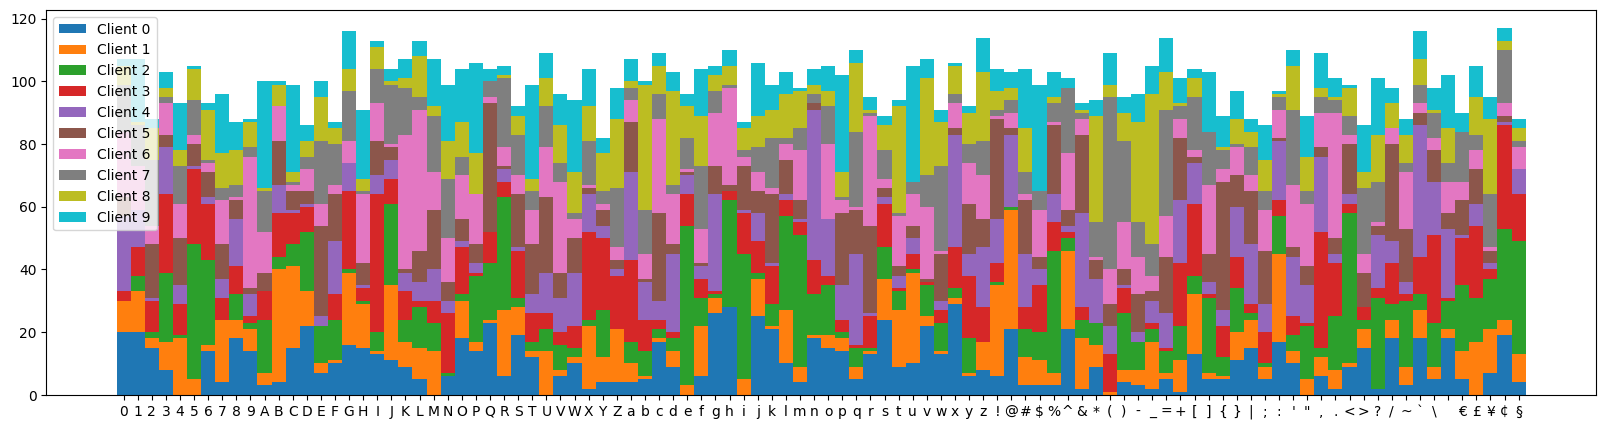

In [3]:
plt.figure(figsize=(20,5))
plt.hist([train_labels[idc]for idc in client_idcs], stacked=True, 
         bins=np.arange(min(train_labels)-0.5, max(train_labels) + 1.5, 1),
        label=["Client {}".format(i) for i in range(N_CLIENTS)])
plt.xticks(np.arange(100), mapp)
plt.legend()
plt.show()

Next, we simulate a clustering structure in the client population, by rotating the data for half of the first 5 clients by 180 degree. We display 10 data samples from the 1st and the 6th client for illustration.

In [4]:
for i, client_datum in enumerate(client_data):
    if i<5:
        client_datum.subset_transform = transforms.Compose([transforms.RandomRotation((180,180)),
                                                      transforms.ToTensor()])
    else:
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

In [5]:
clients = [Client(ConvNet, lambda x : torch.optim.SGD(x, lr=1e-3, momentum=0.9), dat, idnum=i) 
           for i, dat in enumerate(client_data)]
server = Server(ConvNet, test_data)

Client 0:


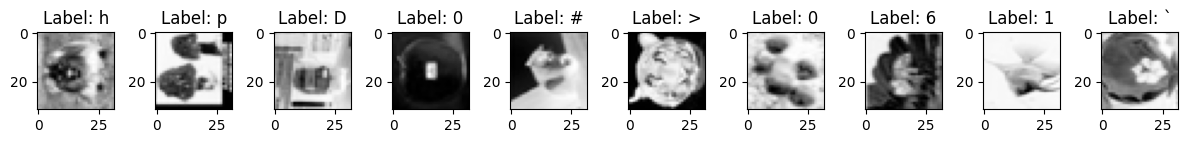

Client 3:


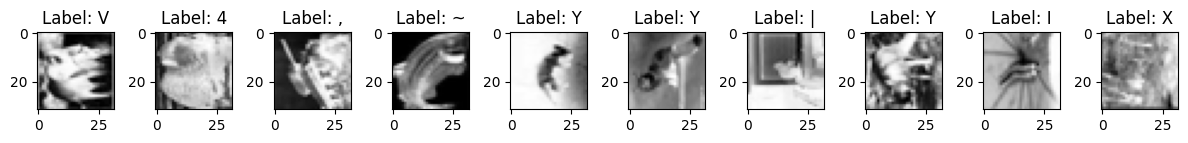

In [6]:
for client in [clients[0], clients[3]]:
    x, y = next(iter(client.train_loader))

    print("Client {}:".format(client.id))
    
    plt.figure(figsize=(15,1))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i,0].numpy().T, cmap="Greys")
        plt.title("Label: {}".format(mapp[y[i].item()]))
    plt.show()

Now everything is set up to run our Clustered Federated Learning algorithm. During training, we will track the mean and std client accuracies, as well as the average and maximum client update norms.

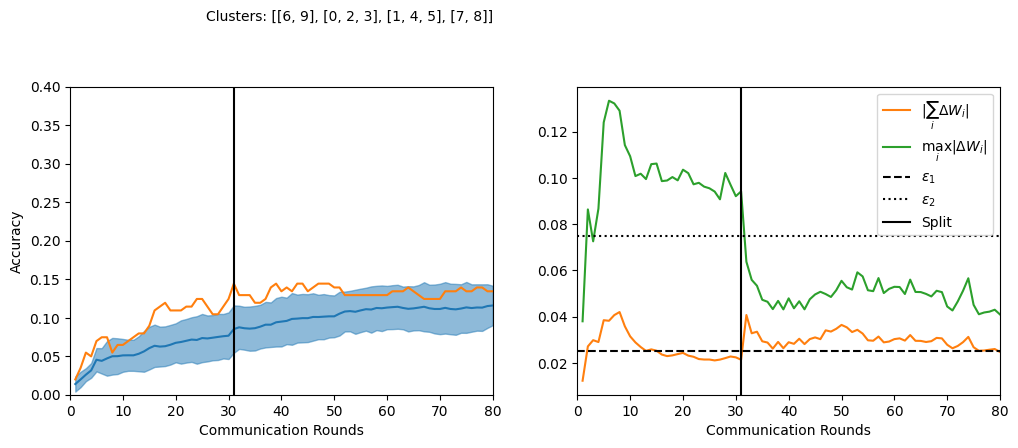

In [7]:
COMMUNICATION_ROUNDS = 80
EPS_1 = 0.025
EPS_2 = 0.075
    
    
cfl_stats = ExperimentLogger()
    
cluster_indices = [np.arange(len(clients)).astype("int")]
client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
client_baseline = Client(ConvNet, lambda x : torch.optim.SGD(x, lr=1e-3, momentum=0.9), client_data[0], 0)
baseline = []

for c_round in range(1, COMMUNICATION_ROUNDS+1):

    if c_round == 1:
        for client in clients:
            client.synchronize_with_server(server)
            
    participating_clients = server.select_clients(clients, frac=1.0)

    for client in participating_clients:
        train_stats = client.compute_weight_update(epochs=5)
        client.reset()
    client_baseline.compute_weight_update(epochs=5)
    client.reset()

    similarities = server.compute_pairwise_similarities(clients)

    cluster_indices_new = []
    for idc in cluster_indices:
        max_norm = server.compute_max_update_norm([clients[i] for i in idc])
        mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])
             
        if mean_norm<EPS_1 and max_norm>EPS_2 and len(idc)>2 and c_round>30:
            
            server.cache_model(idc, clients[idc[0]].W, acc_clients)
            
            c = server.cluster_clients(similarities[idc][:,idc]) 
            cluster_indices_new += c
             
            cfl_stats.log({"split" : c_round})

        else:
            cluster_indices_new += [idc]
        
        
    cluster_indices = cluster_indices_new
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

    server.aggregate_clusterwise(client_clusters)

    acc_clients = [client.evaluate() for client in clients]
    baseline  += [client_baseline.evaluate()]
    
    cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                  "rounds" : c_round, "clusters" : cluster_indices})
    
    
    display_train_stats(cfl_stats, baseline, EPS_1, EPS_2, COMMUNICATION_ROUNDS)

    
for idc in cluster_indices:    
    server.cache_model(idc, clients[idc[0]].W, acc_clients)

The training process resulted in multiple models for every client: A Federated Learning base model as well as more specialized models for the different clusters.  We can now compare their accuracies on the clients' validation sets, and assign each client the model which performed best.

In [8]:
results = np.zeros([10, len(server.model_cache)])
for i, (idcs, W, accs) in enumerate(server.model_cache):
    results[idcs, i] = np.array(accs)

In [9]:
frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i) 
                                                    for i in range(results.shape[1]-1)],
            index = ["Client {}".format(i) for i in range(results.shape[0])])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
frame.T.style.apply(highlight_max)

,Client 0,Client 1,Client 2,Client 3,Client 4,Client 5,Client 6,Client 7,Client 8,Client 9
FL Model,0.054726,0.093923,0.021277,0.050505,0.105528,0.084158,0.064516,0.132653,0.094241,0.064865
Model 0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.138249,0.000000,0.000000,0.091892
Model 1,0.109453,0.000000,0.068085,0.085859,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Model 2,0.000000,0.127072,0.000000,0.000000,0.155779,0.118812,0.000000,0.000000,0.000000,0.000000
Model 3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127551,0.136126,0.000000


As we can see, clustering improoved the accuracy for all clients by about 10%.